In [ ]:
import os, sys
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import (GlobalMaxPooling2D,
    BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline
           
from google.colab import drive
drive.mount('/content/drive')

import pathlib


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
print(os.listdir("/content/drive/MyDrive/Colab Notebooks/deep_learning_project/datasets/deep_learning_project/"))

Mounted at /content/drive
['assignment_instructions.docx', 'dataset1', 'dataset2', 'vgg16']


In [ ]:
import tensorflow as tf

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

# Set the numpy seed
np.random.seed(111)

# Disable multi-threading in tensorflow ops
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Set the random seed in tensorflow at graph level
tf.random.set_seed(111)

# Define a tensorflow session with above session configs
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

In [ ]:
# Define path to the data directory
data_dir = Path('/content/drive/MyDrive/Colab Notebooks/deep_learning_project/datasets/deep_learning_project/dataset1/known_images/UltraSoundImages')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [ ]:
# Get the path to the normal and sick sub-directories
normal_cases_dir = train_dir / 'NORMAL'
sick_cases_dir = train_dir / 'SICK'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.png')
sick_cases = sick_cases_dir.glob('*.png')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the sick cases. The label for these cases will be 1
for img in sick_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,/content/drive/MyDrive/Colab Notebooks/deep_le...,1
1,/content/drive/MyDrive/Colab Notebooks/deep_le...,0
2,/content/drive/MyDrive/Colab Notebooks/deep_le...,0
3,/content/drive/MyDrive/Colab Notebooks/deep_le...,1
4,/content/drive/MyDrive/Colab Notebooks/deep_le...,1


1    245
0    245
Name: label, dtype: int64


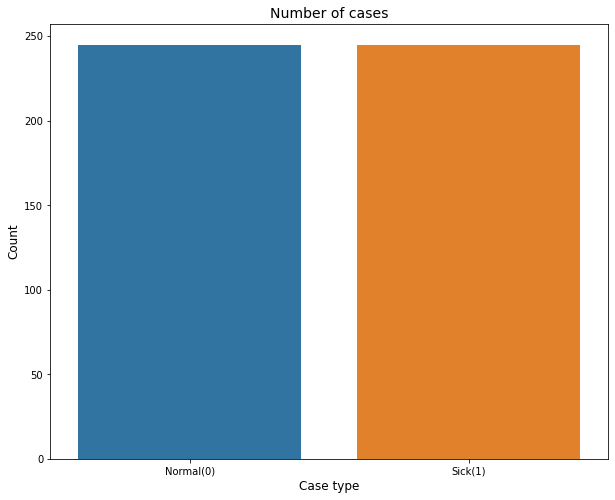

In [ ]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Sick(1)'])
plt.show()

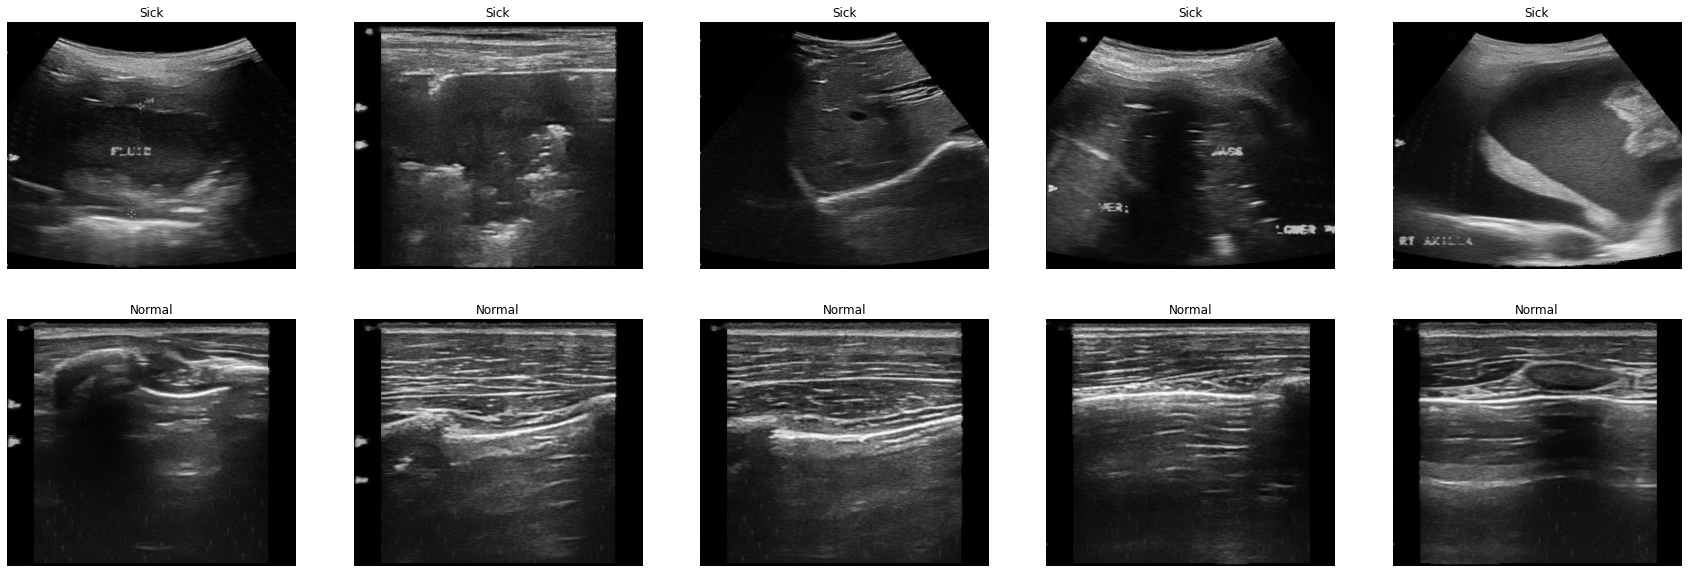

In [ ]:
# Get few samples for both the classes
sick_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = sick_samples + normal_samples
del sick_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Sick")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [ ]:
# Get the path to the sub-directories
normal_cases_dir = val_dir / 'NORMAL'
sick_cases_dir = val_dir / 'SICK'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.png')
sick_cases = sick_cases_dir.glob('*.png')

# List that are going to contain validation images data and the corresponding labels
valid_data = []
valid_labels = []


# Some images are in grayscale while majority of them contains 3 channels. So, if the image is grayscale, we will convert into a image with 3 channels.
# We will normalize the pixel values and resizing all the images to 224x224 

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# sick cases        
for img in sick_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# Convert the list into numpy arrays
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (106, 224, 224, 3)
Total number of labels: (106, 2)


In [ ]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [ ]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Initialize a counter
    i =0
    while True:
        np.random.shuffle(indices)
        # Get the next batch 
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # one hot encoding
            encoded_label = to_categorical(label, num_classes=2)
            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==1 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [ ]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [ ]:
model =  build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [ ]:
# Open the VGG16 weight file
f = h5py.File('/content/drive/MyDrive/Colab Notebooks/deep_learning_project/datasets/deep_learning_project/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# Select the layers for which you want to set weight.

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 Conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 Conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 Conv2_1 (SeparableConv2D)   (None, 112, 112, 128)     8896      
                                                                 
 Conv2_2 (SeparableConv2D)   (None, 112, 112, 128)     17664     
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [ ]:
# opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
batch_size = 4
nb_epochs = 50

# Get a train data generator
train_data_gen = data_gen(data=train_data, batch_size=batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 122 and 106


In [ ]:
# Fit the model
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_data, valid_labels),callbacks=[es, chkpt],
                              class_weight={0:1.0, 1:0.4})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/50
122/122 [==============================] - 26s 199ms/step - loss: 0.3610 - accuracy: 0.6824 - val_loss: 0.7323 - val_accuracy: 0.4906
Epoch 2/50
122/122 [==============================] - 15s 120ms/step - loss: 0.2711 - accuracy: 0.7787 - val_loss: 0.9049 - val_accuracy: 0.4906
Epoch 3/50
122/122 [==============================] - 18s 147ms/step - loss: 0.1677 - accuracy: 0.8955 - val_loss: 0.7283 - val_accuracy: 0.4906
Epoch 4/50
122/122 [==============================] - 17s 143ms/step - loss: 0.1342 - accuracy: 0.9467 - val_loss: 0.4223 - val_accuracy: 0.8679
Epoch 5/50
122/122 [==============================] - 17s 139ms/step - loss: 0.0749 - accuracy: 0.9385 - val_loss: 0.2975 - val_accuracy: 0.8679
Epoch 6/50
122/122 [==============================] - 17s 138ms/step - loss: 0.0958 - accuracy: 0.9385 - val_loss: 0.2008 - val_accuracy: 0.9245
Epoch 7/50
122/122 [==============================] - 12s 97ms/step - loss: 0.0666 - accuracy: 0.9672 - val_loss: 0.2365 - val_acc

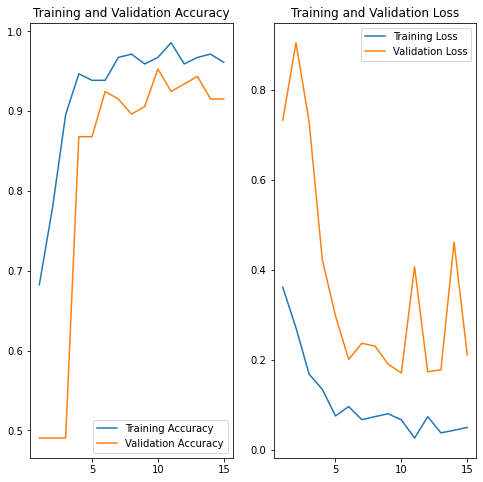

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(nb_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(acc)+1),acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc)+1),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss)+1),loss, label='Training Loss')
plt.plot(range(1, len(val_loss)+1), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# # Load the model weights
# model.load_weights("/content/drive/MyDrive/Colab Notebooks/deep_learning_project/datasets/deep_learning_project/vgg16/best_model.hdf5")

In [ ]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
sick_cases_dir = test_dir / 'SICK'

normal_cases = normal_cases_dir.glob('*.png')
sick_cases = sick_cases_dir.glob('*.png')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in sick_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (110, 224, 224, 3)
Total number of labels: (110, 2)


In [ ]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

7/7 [==============================] - 3s 248ms/step - loss: 0.1788 - accuracy: 0.9455
Loss on test set:  0.1788214147090912
Accuracy on test set:  0.9454545378684998


In [ ]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(110,)
(110,)


<Figure size 432x288 with 0 Axes>

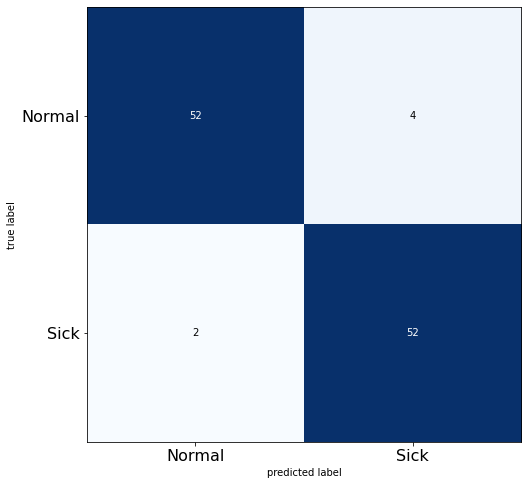

In [ ]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
#alpha=0.7,
plt.xticks(range(2), ['Normal', 'Sick'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Sick'], fontsize=16)
plt.show()

In [ ]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.96
Precision of the model is 0.93


In [ ]:
# model.save('/content/drive/MyDrive/Colab Notebooks/deep_learning_project/datasets')

In [ ]:
dataset2_dir = Path('/content/drive/MyDrive/Colab Notebooks/deep_learning_project/datasets/deep_learning_project/dataset2/images')

# test_dir = data_dir / 'test'

In [ ]:
# Preparing test data
normal_cases_dir2 = dataset2_dir / 'NORMAL'
sick_cases_dir2 = dataset2_dir / 'SICK'

normal_cases_dts2 = normal_cases_dir2.glob('*.png')
sick_cases_dts2 = sick_cases_dir2.glob('*.png')

test_data_dts2 = []
test_labels_dts2 = []

for img in normal_cases_dts2:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label_dts2 = to_categorical(0, num_classes=2)
    test_data_dts2.append(img)
    test_labels_dts2.append(label_dts2)
                      
for img in sick_cases_dts2:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label_dts2 = to_categorical(1, num_classes=2)
    test_data_dts2.append(img)
    test_labels_dts2.append(label_dts2)
    

test_data_dts2 = np.array(test_data_dts2)
test_labels_dts2 = np.array(test_labels_dts2)

print("Total number of test examples: ", test_data_dts2.shape)
print("Total number of labels:", test_labels_dts2.shape)

Total number of test examples:  (224, 224, 224, 3)
Total number of labels: (224, 2)


In [ ]:
# Evaluation on test dataset
test_loss_dts2, test_score_dts2 = model.evaluate(test_data_dts2, test_labels_dts2, batch_size=16)
print("Loss on test set: ", test_loss_dts2)
print("Accuracy on test set: ", test_score_dts2)

14/14 [==============================] - 1s 54ms/step - loss: 4.5137 - accuracy: 0.4911
Loss on test set:  4.513689041137695
Accuracy on test set:  0.4910714328289032


In [ ]:
# Get predictions
preds_dts2 = model.predict(test_data_dts2, batch_size=16)
preds_dts2 = np.argmax(preds_dts2, axis=-1)

# Original labels
orig_test_labels_dts2 = np.argmax(test_labels_dts2, axis=-1)

print(orig_test_labels_dts2.shape)
print(preds_dts2.shape)

(224,)
(224,)


<Figure size 432x288 with 0 Axes>

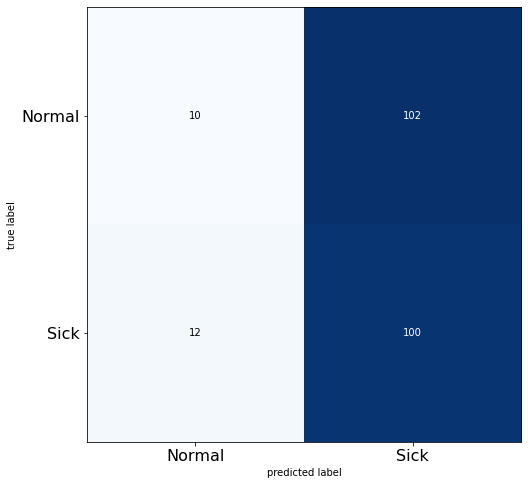

In [ ]:
# Get the confusion matrix
cm_dts2  = confusion_matrix(orig_test_labels_dts2, preds_dts2)
plt.figure()
plot_confusion_matrix(cm_dts2,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
#alpha=0.7,
plt.xticks(range(2), ['Normal', 'Sick'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Sick'], fontsize=16)
plt.show()

In [ ]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm_dts2.ravel()

precision_dts2 = tp/(tp+fp)
recall_dts2 = tp/(tp+fn)

print("Recall of the model on dataset2 is {:.2f}".format(recall_dts2))
print("Precision of the model on dataset2 is {:.2f}".format(precision_dts2))

Recall of the model on dataset2 is 0.89
Precision of the model on dataset2 is 0.50
